In [1]:
import configparser
import tweepy
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import time
import re
import hashlib
import networkx as nx

In [2]:
# get tokens
config = configparser.ConfigParser()
config.read('configfile.ini')
api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']
# authenticate
auth = tweepy.OAuth2AppHandler(api_key, api_key_secret)

In [3]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
def get_tweets_dataframe(working_df, tweets, hashtag):
    #working_df=working_df.drop_duplicates()
    print(f'working on {hashtag}')
    index=len(working_df)
    for tweet in tweets: 
        working_df.loc[index,'tweet_id']=tweet.id
        working_df.loc[index,'created_at']=tweet.created_at
        working_df.loc[index,'user']=tweet.user.screen_name
        working_df.loc[index,'full_text']=tweet.full_text
        working_df.loc[index,'favorite_count']=tweet.favorite_count
        working_df.loc[index,'retweet_count']=tweet.retweet_count
        working_df.loc[index,'hashtags']=hashtag
        #print(working_df.loc[index,'created_at'])
        #working_df=working_df.drop_duplicates()
        index+=1
        working_df.to_csv(f'tweeterhashtags/{hashtag}.csv', index=False)
        #time.sleep(1)
    working_df=working_df.drop_duplicates()
    working_df.to_csv(f'tweeterhashtags/{hashtag}.csv', index=False)
    working_df['created_at'] = pd.to_datetime(working_df['created_at'], utc=True)
    # Group the DataFrame by day
    grouped_df = working_df.groupby(pd.Grouper(key='created_at', freq='D'))

    # Calculate the count of rows for each day
    count_per_day = grouped_df['hashtags'].count()

    # Display the count per day
    print(count_per_day)
          
    return working_df

In [5]:
def get_tweets_from_general_tags(working_df, hashtag):
    #load and merge the general_tags
    print(f'working on {hashtag}')
    general_tags = ['#SaveLockwoodandCo', 'Lockwood and Co']
    general_tags_df=pd.DataFrame()
    for tag in general_tags:
        try:
            general_tags_df=pd.concat([general_tags_df, pd.read_csv(f'tweeterhashtags/{tag}.csv')], ignore_index=True)
        except:
            pass
    general_tags_df =general_tags_df.drop_duplicates()
    print(f'total generaltags: {len(general_tags_df)}')
    #general_tags_df['full_text'] = general_tags_df['full_text'].apply(lambda x: x.replace('\n',' ').replace(':', ' '))
    #Get the rows in the working_df that have the hashtag inside the full_text column
    hashtag_df = general_tags_df[general_tags_df['full_text'].apply(lambda x: hashtag.lower() in x.lower())]
    #hashtag_df = hashtag_df.reset_index(drop=True)
    hashtag_df['hashtags'] = hashtag
    working_df=pd.concat([working_df, hashtag_df], ignore_index=True)
    working_df=working_df.drop_duplicates()
    working_df['full_text'] = working_df['full_text'].apply(lambda x: x.replace('\n',' ').replace(':', ' '))
    working_df.to_csv(f'tweeterhashtags/{hashtag}.csv', index=False)
    working_df['created_at'] = pd.to_datetime(working_df['created_at'], utc=True)
    # Group the DataFrame by day
    grouped_df = working_df.groupby(pd.Grouper(key='created_at', freq='D'))

    # Calculate the count of rows for each day
    count_per_day = grouped_df['hashtags'].count()

    # Display the count per day
    print(count_per_day)
  
    return working_df

In [6]:
# Create a hash function to generate anonymized values
def anonymize(value):
    # Convert the value to a string and hash it using SHA256 algorithm
    hashed_value = hashlib.sha256(str(value).encode()).hexdigest()
    # Take the first 8 characters of the hash as the anonymized value
    anonymized_value = hashed_value[:8]
    return anonymized_value

In [7]:
hashtagsweek1 = ['#FridayNightatPortlandRow', '#HauntedWatchParty', '#WatchPartyatPortlandRow', '#HauntedbyaType3','#TogetherForLockwoodandCo','#PrimeForLockwoodandCo','#BringBackLockwoodandCo']
hashtagsweek2 = ['#GhostHuntersWatchParty', '#DisneyForLockwoodandCo', '#BBCforLockwoodandCo', '#AppleTVforLockwoodandCo', '#PrimeForLockwoodandCo', '#JustRecklessEnough']
hashtagsweek3 = ['#LockwoodGhostAuditions', '#ParamountForLockwoodandCo', '#ScullandCo','#RapiersReady', '#CaringforCarlyle', '#DEPRACisOnTheWay', '#BunsForBunchurch']
hashtagsweek4 = ['#CompleteFictionAppreciation', '#DisneySaveLockwood', '#ArtistryofLockwoodandCo', '#ParamountSaveLockwood', '#GhostStrike', '#LockwoodParallelFandoms', '#JustRecklessEnough']
hashtagsweek5 = ['#StroudsAppreciation', '#VoteLockwoodforNFA', '#PrimeSaveLockwood', '#ScreamingStaircase', '#DEPRACrollcall', '#LivingforLockwood', '#RapiersReady']
hashtagsall = hashtagsweek1+hashtagsweek2+hashtagsweek3+hashtagsweek4 + hashtagsweek5
hashtagsall = list(set(hashtagsall))

In [31]:

phrase = 'Lockwood and Co'
try:
    working_df = pd.read_csv(f'tweeterhashtags/{phrase}.csv')
    print(len(working_df))
except:
    working_df = pd.DataFrame(columns=['tweet_id', 'created_at', 'user', 'full_text', 'favorite_count', 'retweet_count', 'hashtags'])
    
tweets = tweepy.Cursor(api.search_tweets, q=phrase, tweet_mode='extended').items()
working_df = get_tweets_dataframe(working_df, tweets, phrase)
    
working_df.drop_duplicates(inplace=True)
print(len(working_df))
    
time.sleep(60)

hashtag = '#SaveLockwoodandCo'
try:
    working_df = pd.read_csv(f'tweeterhashtags/{phrase}.csv')
    print(len(working_df))
except:
    working_df = pd.DataFrame(columns=['tweet_id', 'created_at', 'user', 'full_text', 'favorite_count', 'retweet_count', 'hashtags'])
    
tweets = tweepy.Cursor(api.search_tweets, q=hashtag, tweet_mode='extended').items()
working_df = get_tweets_dataframe(working_df, tweets, phrase)
    
working_df.drop_duplicates(inplace=True)
print(len(working_df))
    
time.sleep(60)


19990
working on Lockwood and Co


/tmp/ipykernel_494/1434055682.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['created_at'] = pd.to_datetime(working_df['created_at'], utc=True)


created_at
2023-06-02 00:00:00+00:00      64
2023-06-03 00:00:00+00:00     313
2023-06-04 00:00:00+00:00     275
2023-06-05 00:00:00+00:00     443
2023-06-06 00:00:00+00:00     725
2023-06-07 00:00:00+00:00     922
2023-06-08 00:00:00+00:00    1159
2023-06-09 00:00:00+00:00    1710
2023-06-10 00:00:00+00:00    1937
2023-06-11 00:00:00+00:00    2756
2023-06-12 00:00:00+00:00     407
2023-06-13 00:00:00+00:00       0
2023-06-14 00:00:00+00:00       0
2023-06-15 00:00:00+00:00    1778
2023-06-16 00:00:00+00:00     276
Freq: D, Name: hashtags, dtype: int64
12765
12765
working on Lockwood and Co
created_at
2023-06-02 00:00:00+00:00      64
2023-06-03 00:00:00+00:00     313
2023-06-04 00:00:00+00:00     275
2023-06-05 00:00:00+00:00     443
2023-06-06 00:00:00+00:00     725
2023-06-07 00:00:00+00:00     922
2023-06-08 00:00:00+00:00    1159
2023-06-09 00:00:00+00:00    1710
2023-06-10 00:00:00+00:00    1937
2023-06-11 00:00:00+00:00    2756
2023-06-12 00:00:00+00:00     407
2023-06-13 00:00:

In [36]:
hashtags = ['#DEPRACrollcall']
for hashtag in hashtags:
    try:
        working_df=pd.read_csv(f'tweeterhashtags/{hashtag}.csv')
        #working_df = pd.read_csv('tweeterhashtags/#SkullandCo.csv')
        print(len(working_df))
    except:
        working_df=pd.DataFrame(columns=['tweet_id','created_at', 'user', 'full_text','favorite_count','retweet_count','hashtags'])
    tweets = tweepy.Cursor(api.search_tweets, q=hashtag, tweet_mode='extended').items()
    working_df = get_tweets_dataframe(working_df, tweets, hashtag)
    working_df=working_df.drop_duplicates()
    print(len(working_df))
    time.sleep(60)

10
working on #DEPRACrollcall
created_at
2023-06-15 00:00:00+00:00     16
2023-06-16 00:00:00+00:00    191
Freq: D, Name: hashtags, dtype: int64
207


In [10]:
hashtags = ['#SkullandCo']
for hashtag in hashtagsall:
    try:
        
        working_df=pd.read_csv(f'tweeterhashtags/{hashtag}.csv')
        print('try')
        working_df = get_tweets_from_general_tags(working_df, hashtag)
    except:
        working_df=pd.DataFrame(columns=['tweet_id','created_at', 'user', 'full_text','favorite_count','retweet_count','hashtags'])
        print('except')
        working_df = get_tweets_from_general_tags(working_df, hashtag)
        

try
working on #HauntedWatchParty
total generaltags: 60207
created_at
2023-05-20 00:00:00+00:00    3433
2023-05-21 00:00:00+00:00    1237
2023-05-22 00:00:00+00:00     112
2023-05-23 00:00:00+00:00      38
2023-05-24 00:00:00+00:00       0
2023-05-25 00:00:00+00:00       3
2023-05-26 00:00:00+00:00       0
2023-05-27 00:00:00+00:00      10
2023-05-28 00:00:00+00:00       0
2023-05-29 00:00:00+00:00       0
2023-05-30 00:00:00+00:00       0
2023-05-31 00:00:00+00:00       1
2023-06-01 00:00:00+00:00       0
2023-06-02 00:00:00+00:00       0
2023-06-03 00:00:00+00:00       2
2023-06-04 00:00:00+00:00       2
Freq: D, Name: hashtags, dtype: int64
try
working on #ParamountForLockwoodandCo


/tmp/ipykernel_494/3358370044.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hashtag_df['hashtags'] = hashtag


total generaltags: 60207
created_at
2023-05-28 00:00:00+00:00       1
2023-05-29 00:00:00+00:00      38
2023-05-30 00:00:00+00:00    7066
2023-05-31 00:00:00+00:00    2501
2023-06-01 00:00:00+00:00     144
2023-06-02 00:00:00+00:00      15
2023-06-03 00:00:00+00:00       8
2023-06-04 00:00:00+00:00      12
2023-06-05 00:00:00+00:00      12
2023-06-06 00:00:00+00:00       4
2023-06-07 00:00:00+00:00       6
2023-06-08 00:00:00+00:00     110
2023-06-09 00:00:00+00:00      12
2023-06-10 00:00:00+00:00       3
2023-06-11 00:00:00+00:00       2
Freq: D, Name: hashtags, dtype: int64
try
working on #LockwoodGhostAuditions
total generaltags: 60207
created_at
2023-05-28 00:00:00+00:00      40
2023-05-29 00:00:00+00:00    5292
2023-05-30 00:00:00+00:00    1072
2023-05-31 00:00:00+00:00      41
2023-06-01 00:00:00+00:00      11
2023-06-02 00:00:00+00:00       2
2023-06-03 00:00:00+00:00       2
2023-06-04 00:00:00+00:00       2
2023-06-05 00:00:00+00:00       0
2023-06-06 00:00:00+00:00       1
2

In [11]:
working_df=pd.DataFrame()
for hashtag in hashtagsall:
    try:
        working_df=pd.concat([working_df, pd.read_csv(f'tweeterhashtags/{hashtag}.csv')], ignore_index=True)
    except:
        pass
len(working_df)

181538

In [12]:
working_df['full_text'] = working_df['full_text'].str.replace(r'"', '').replace(r'\n', ' ').replace(':', ' ')
working_df['full_text']

0         RT @Lockwood1494  In the past 24 hours I have ...
1         RT @onebignxthing  we made it to CBR! @DisneyP...
2         RT @afflictionism  @Godsgirljune i offer to yo...
3         RT @afflictionism  @Godsgirljune i offer to yo...
4         RT @jalynp  Anybody done artwork of the agency...
                                ...                        
181533    No but seriously @netflix Lockwood and Co is a...
181534    episode 7 of lockwood&amp;co has to be my favo...
181535    Here's another favourite Lockwood edit (this o...
181536    me every time i see n*tflix on my tl still lea...
181537    Since it got cancelled the only thing I have w...
Name: full_text, Length: 181538, dtype: object

In [13]:
# Create a new column 'retweet' with default value False
working_df['retweet'] = False

# Check if 'full_text' starts with 'RT ' and set 'retweet' column accordingly
working_df.loc[working_df['full_text'].str.startswith('RT '), 'retweet'] = True

working_df['retweet'].value_counts()

False    96679
True     84859
Name: retweet, dtype: int64

In [14]:
def get_week_label(week_number):
    if week_number == 20:
        return 'week1'
    elif week_number == 21:
        return 'week2'
    elif week_number == 22:
        return 'week3'
    elif week_number == 23:
        return 'week4'
    elif week_number == 24:
        return 'week5'
    else:
        return 'week1'


In [15]:
working_df['created_date'] = pd.to_datetime(working_df['created_at'], utc=True)
working_df['week'] = working_df['created_date'].dt.isocalendar().week
working_df['week'] = working_df['week'].apply(get_week_label)
working_df['week'].value_counts()

/tmp/ipykernel_494/1902887933.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  working_df['week'] = working_df['created_date'].dt.week


week4    45681
week1    45386
week3    45239
week2    36116
week5     9116
Name: week, dtype: int64

In [16]:
#Create an anonymized tweet_id
#working_df['unique_id'] = str(working_df['tweet_id']) + working_df['created_at'] + working_df['user'] + str(working_df['retweet'])
working_df['unique_id'] = working_df.apply(lambda row: str(row['tweet_id']) + row['created_at'] + row['user'] + str(row['retweet']), axis=1)
working_df['tweet_id'] = working_df['unique_id'].apply(anonymize)

In [17]:
hashtags_df = working_df[['tweet_id','hashtags']]
hashtags_df.to_csv('output/hashtags.csv', index=False)
working_df.value_counts('hashtags')

hashtags
#JustRecklessEnough             18365
#PrimeForLockwoodandCo          15220
#ParamountForLockwoodandCo       9934
#TogetherForLockwoodandCo        9413
#BunsForBunchurch                9265
#ParamountSaveLockwood           9158
#CompleteFictionAppreciation     8745
#BringBackLockwoodandCo          7824
#RapiersReady                    7310
#LockwoodParallelFandoms         6781
#LockwoodGhostAuditions          6464
#CaringforCarlyle                6280
#GhostStrike                     5883
#DisneyForLockwoodandCo          5848
#HauntedbyaType3                 5810
#DEPRACisOnTheWay                5410
#BBCforLockwoodandCo             5377
#WatchPartyatPortlandRow         5255
#FridayNightatPortlandRow        5207
#DisneySaveLockwood              5013
#HauntedWatchParty               4838
#AppleTVforLockwoodandCo         4744
#GhostHuntersWatchParty          4249
#StroudsAppreciation             2835
#ScreamingStaircase              2556
#ArtistryofLockwoodandCo         2023
#Vo

In [18]:
working_df=working_df.drop_duplicates('tweet_id')
working_df['tagged_users'] = working_df['full_text'].apply(lambda x: re.findall(r'@(\w+)', x))
working_df['tagged_users']

0                    [Lockwood1494, netflix, DisneyPlus]
1         [onebignxthing, DisneyPlus, primevideouk, BBC]
2                          [afflictionism, Godsgirljune]
3                          [afflictionism, Godsgirljune]
4                                               [jalynp]
                               ...                      
179339                                   [RebekahBlazek]
179341                                                []
179343                                                []
179346                                                []
179347                  [lavenderghostco, whatonnetflix]
Name: tagged_users, Length: 127834, dtype: object

In [19]:
#Create a table for network analysis
na_df = working_df[['tweet_id','user', 'retweet', 'tagged_users']]
#na_df = na_df.drop_duplicates()
na_df

,tweet_id,user,retweet,tagged_users
0,95961083,Juliebean512,True,"[Lockwood1494, netflix, DisneyPlus]"
1,61d048d9,Juliebean512,True,"[onebignxthing, DisneyPlus, primevideouk, BBC]"
2,a96a087c,antigone_aela,True,"[afflictionism, Godsgirljune]"
3,f4d3534f,rayningwater,True,"[afflictionism, Godsgirljune]"
4,0e84e228,Earthling738,True,[jalynp]
...,...,...,...,...
179339,49a63588,biscuitandco,False,[RebekahBlazek]
179341,cae04814,Awklepuff,False,[]
179343,71b1c3a5,Valentini_Elly,False,[]
179346,7e57b8a3,Godsgirljune,False,[]


In [20]:
#Create a function that would create a dataframe that shows the interaction
def get_interaction(df):
    func_df = pd.DataFrame(columns = ['tweet_id', 'from', 'to'])
    for x in range(len(df)):
        if df['retweet'][0]=='True':
            new_row = {'tweet_id':df['tweet_id'].iloc[x], 'from':df['tagged_users'].iloc[x][0], 'to': df['user'].iloc[x]}
            func_df = func_df.append(new_row, ignore_index = True)
        else:
            for user in df['tagged_users'].iloc[x]:
                new_row = {'tweet_id':df['tweet_id'].iloc[x], 'to':user, 'from': df['user'].iloc[x]}
                func_df = func_df.append(new_row, ignore_index = True)
    return func_df.drop_duplicates()


In [21]:
na_interac_df = get_interaction(na_df)
na_interac_df

,tweet_id,from,to
0,95961083,Juliebean512,Lockwood1494
1,95961083,Juliebean512,netflix
2,95961083,Juliebean512,DisneyPlus
3,61d048d9,Juliebean512,onebignxthing
4,61d048d9,Juliebean512,DisneyPlus
...,...,...,...
145048,63609a73,biscuitandco,lavenderghostco
145049,c6280a7a,biscuitandco,lavenderghostco
145050,49a63588,biscuitandco,RebekahBlazek
145051,33d07f31,Awklepuff,lavenderghostco


In [22]:
#get a unique user dataframe
list_of_user = na_interac_df['from'].append(na_interac_df['to'], ignore_index=True)
list_of_user = list(set(list_of_user))
user_df = pd.DataFrame(list_of_user, columns=['username'])
user_df['user'] = user_df['username'].apply(anonymize)
user_df=user_df.sort_values('username').reset_index()
user_df.to_csv('output/username.csv', index=False)

In [23]:
#anonymise the users from the different dataframes
na_interac_df['from'] = na_interac_df['from'].map(user_df.set_index('username')['user'])
na_interac_df['to'] = na_interac_df['to'].map(user_df.set_index('username')['user'])
working_df['user'] = working_df['user'].map(user_df.set_index('username')['user'])
na_interac_df.to_csv('output/userinteraction.csv', index=False)

In [24]:
na_interac_df = pd.read_csv('output/userinteraction.csv')

In [25]:
interac_grouped_df = na_interac_df.groupby(['from','to',])['tweet_id'].count().reset_index().sort_values(by='tweet_id',ascending=False).reset_index()
interac_grouped_df

,index,from,to,tweet_id
0,299,019f08f0,e1362151,574
1,5973,27a03938,e1362151,559
2,34112,facd6e5a,e1362151,497
3,10446,4c4c7309,e1362151,477
4,531,022e1f18,13ed0704,468
...,...,...,...,...
34641,15150,72de54f0,429542c4,1
34642,15148,72de54f0,3f65fdad,1
34643,15144,72de54f0,2d37695c,1
34644,15142,72de54f0,2a593ea6,1


In [26]:
num_tweets = interac_grouped_df.groupby('from')['tweet_id'].sum().sort_values(ascending=False).reset_index()

In [27]:
try_lang = interac_grouped_df[interac_grouped_df['tweet_id']>50]
try_lang

,index,from,to,tweet_id
0,299,019f08f0,e1362151,574
1,5973,27a03938,e1362151,559
2,34112,facd6e5a,e1362151,497
3,10446,4c4c7309,e1362151,477
4,531,022e1f18,13ed0704,468
...,...,...,...,...
343,23215,b0df6303,15ddc837,51
344,30428,e1362151,e9a05361,51
345,14889,6fcf78f0,a6cd32f5,51
346,22761,abf2b04c,6020a7e0,51


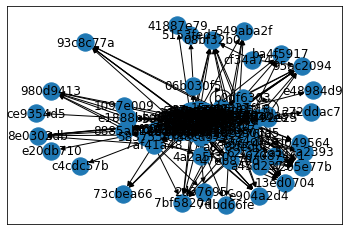

In [28]:
G = nx.from_pandas_edgelist(try_lang, source = 'from', target = 'to', edge_attr='tweet_id', create_using=nx.DiGraph())
nx.draw_networkx(G, with_labels=True)

In [29]:
working_df = working_df[['tweet_id', 'created_at', 'user', 'full_text', 'favorite_count', 'retweet_count', 'retweet', 'week']]
working_df.to_csv('output/tweets.csv', index=False)
working_df

,tweet_id,created_at,user,full_text,favorite_count,retweet_count,retweet,week
0,95961083,2023-05-27 22:04:54+00:00,779018f5,RT @Lockwood1494 In the past 24 hours I have ...,0.0,92.0,True,week2
1,61d048d9,2023-05-27 22:04:43+00:00,779018f5,RT @onebignxthing we made it to CBR! @DisneyP...,0.0,152.0,True,week2
2,a96a087c,2023-05-27 19:03:31+00:00,fb26c3d9,RT @afflictionism @Godsgirljune i offer to yo...,0.0,4.0,True,week2
3,f4d3534f,2023-05-27 18:48:35+00:00,08fff75f,RT @afflictionism @Godsgirljune i offer to yo...,0.0,4.0,True,week2
4,0e84e228,2023-05-27 16:06:04+00:00,5bfcc584,RT @jalynp Anybody done artwork of the agency...,0.0,1.0,True,week2
...,...,...,...,...,...,...,...,...
179339,49a63588,2023-06-03 07:41:01+00:00,80db4692,@RebekahBlazek Haha 😆 hope the plant is ok 😅 #...,0.0,0.0,False,week3
179341,cae04814,2023-06-03 06:46:56+00:00,2b589a69,EXCUSE ME WHAT THE ACTUAL F**K 😢😢😢 #SaveLockwo...,0.0,0.0,False,week3
179343,71b1c3a5,2023-06-03 05:44:10+00:00,8a842023,Dad deserves a day off xD #SaveLockwoodandCo ...,7.0,0.0,False,week3
179346,7e57b8a3,2023-06-03 03:44:41+00:00,27a03938,"What a happy Friday, Locknation! It was SUCH a...",28.0,3.0,False,week3


In [30]:
set(hashtags_df['tweet_id'])==set(working_df['tweet_id'])

True